# "Jak robimy zdjęcia" na podstawie danych z 500px.com
#### Jakub Czarnowicz

## __Spis treści__

1. __Wstęp__
2. __Data Mining__
3. __Kategorie fotografii__
4. __Koszt ekwipunku__
6. __Tagi__
7. __Lokalizacje__
8. __Użyte biblioteki__
9. __Podsumowanie i wnioski__

## 1. Wstęp

Wraz ze spadkiem cen elektroniki oraz wzrostem dostępności do multimediów popularność fotografii gruntownie wzrosła. Obecnie niemal każdy ma przy sobie urządzenie potrafiące robić zdjęcia. Czy jednak to wystarczy do sukcesu? Jak ma się wiedza techniczna zdobywana na kursach do realiów fotografii? Czy słynne hasło "Nie potrzeba drogiego sprzętu, żeby robić świetne zdjęcia" jest faktem, czy tylko sloganem? Co i gdzie tak naprawdę fotografujemy? W niniejszej pracy spróbuję podjąć się próby odpowiedzi na te pytania poprzez analizę danych z serwisu [500px.com](500px.com)

## 2. Data mining

By jak najwięcej dowiedzieć się o fotografiach potrzeba przeanalizować trzy główne aspekty:
1. Same zdjęcia
2. Sprzęt
3. Ludzi

### 2.1. Zdjęcia

Serwis 500px udostępnia publiczne [API](https://github.com/500px/api-documentation). Dzieki niemu możemy pobrać dane zdjęć i część danych ludzi je robiących - technikalia, sprzęt, lokacje. Pewnym ograniczeniem API jest to, że nie mamy dosępu do streamu danych - zdjęcia trzeba wyszukiwać po tagach / słowach kluczowych lub pobierać je wedle kategorii tj. "z tego tygodnia", "popularne", "editors choise". Żeby dane były możliwie losowe, pobierzemy dwa zestawy. Jeden z wyszukiwaniem po kategoriach: portret, reportaż, pejzaż, macro, w celu sprawdzenia podejść do takich typów fotografii. Drugi to kategoria "z tego tygodnia". Oczywiście takie dane potencjalnie mogą być mało miarodajne, ale to najlepsze co oferuje publiczne API.

Z danymi użytkowników jest podobnie. Pobierzemy dane użytkowników z ostatniego tygodnia.

Podsumowując, do zrealizowania zadania pobierzemy:
- Po 25 tys. zdjęć dla każdej z wyżej wymienionych kategorii
- 100 tys. zdjęć z ostatniego tygodnia
- Dane użytkowników dla 25 tys. zdjęć z ostatniego tygodnia

In [1]:
import sys
import requests
import os

PX_API_KEY = "my_api_key"

In [ ]:
# pobieranie danych wedle kategorii
URL = "https://api.500px.com/v1/photos/search?tag={query}&rpp=100&consumer_key={api_key}&page={page}"

os.mkdir(os.path.join(folder, query))

for i in range(1, 250):
    print("Downloading page: ", i)
    response = requests.get(URL.format(query=query, page=i, api_key=PX_API_KEY))
    with open(os.path.join("photos", query, str(i) + ".json"), 'w') as the_file:
        the_file.write(response.content)

In [ ]:
# pobieranie ostatniego tygodnia
URL = "https://api.500px.com/v1/photos?feature=fresh_week&rpp=100&consumer_key={api_key}&page={page}"

count = 1000
for i in range(1, 1000):
    print("Downloading page: ", i)
    response = requests.get(URL.format(page=i, api_key=PX_API_KEY))
    with open(os.path.join("photos_weekly", str(i) + ".json"), 'w') as the_file:
        the_file.write(response.content)

In [ ]:
# pobieranie danych użytkowników
def download_user(user_id):
    path = os.path.join("users", str(user_id))
    if os.path.isfile(path):
        return
    URL = "https://api.500px.com/v1/users/show/?id={user_id}}&consumer_key={api_key}".format(user_id=user_id, api_key=PX_API_KEY)
    response = requests.get(URL)
    with open(path, 'w') as the_file:
        the_file.write(response.content)

### 2.2. Sprzęt

API 500px udostępnia dane o posiadanym sprzęcie w formie napisów - nazwy urządzenia, obiektywu. Żeby zdobyć cenę trzeba poszukać gdzieś indziej.

Próbowałem te dane zdobyć w dwóch miejsach - na Google Shopping oraz na Amazonie. Okazuje się, że Google nie udostępnia żadnego API pozwalającego na sprawne wyszukiwanie cen produktów. API Amazona natomiast istnieje, jednakże jest bardzo kiepsko udokumentowane i wymaga bardzo wielu stopni uwierzytelnienia by móc z niego korzystać.

Okazało się, że najprostrzym sposobem jest pobieranie danych wprost z amazon.com.

In [32]:
#### import sys
import requests
from BeautifulSoup import BeautifulSoup
import urllib
import os
import time

RETRY_LIMIT = 5

def encode_product_name(product):
    return urllib.quote_plus(product).lower()

def get_product_price(product, product_prices):
    try:
        encoded = encode_product_name(product)
    except:
        return 0
    return products_prices.get(encoded, 0)

def download_amazon_price(product):
    try:
        encoded_product = encode_product_name(product)
    except:
        print product, "INVALID NAME"
        return
    path = os.path.join("prices", encoded_product)
    if os.path.isfile(path):
        print product, "ALREADY DOWNLOADED"
        return
    URL = "https://www.amazon.com/s/ref=nb_sb_ss_c_0_21?url=search-alias%3Delectronics&field-keywords={}".format(encoded_product)
    retry = 0
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    while retry < RETRY_LIMIT:
        response = requests.get(URL, headers=headers)
        if response.status_code == 200:
            break
        retry += 1
        print response.status_code
        time.sleep(5)
    if response.status_code != 200:
        return "NOT FOUND"
    soup = BeautifulSoup(response.content)
    lis = soup.findAll("li", "s-result-item  celwidget")
    price = None
    for li in lis:
        if not "sponsored" in li["class"]:
            price = li.find("span", "a-color-price").text
            break
    if price:
        with open(path, 'w') as the_file:
            the_file.write(price)
        print product, price
    else:
        print product, "NOT FOUND"

### 2.3. Ludzie

Tu pojawił się problem - 500px nie podaje zbyt wielu informacji na temat użytkowników. Podaje natomiast id ich portali społecznościowych. Okazuje się jednak, że bez specjalnych zezwoleń API facebooka ukrywa (nawet te publiczne na stronie) dane użytkowników prócz nazwiska, płci i pełnoletności. Twitter podobnie - dane użytkowników są dostępne na stronie ale nie można ich pogbrać po API.

Będziemy musieli się ograniczyć do danych zdobytych z 500px i Amazona.

# 3. Kategorie fotografii

Przyjrzymy się czterem najpopularniejszym kategoriom fotografii: portretowi, pejrzażowi, reportażowi oraz makro. Postaramy się sprawdzić dwie rzeczy: czy ustawienia aparatów są takie, jak sugerują to podręczniki i kursy oraz czy wysoko oceniane fotografie w danej kategorii są robione inaczej niż te mniej popularne.

Żeby uzyskać pogląd na dane zastosujemy Kernel Density Estimation. Dzięki temu będziemy mogli estymować udział zadanych parametrów w fotografiach. Ponieważ wartości mogą być dowolne, zwykły histogram byłby mało pomocny.

Za "popularne" uznamy zdjęcia z wartością 'rating' powyżej 75. To specjalna wartość wyliczana przez 500px, będąca wypadkową liczby wyświetleń i głosów.

Przygotowanie danych:

In [2]:
%matplotlib inline
import json
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import scipy
from fractions import Fraction
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
def import_photos_from_category(category):
    photos = []
    path = os.path.join("photos", category)
    files = os.listdir(path)
    for file_name in files:
        if file_name.endswith(".json"):
            with open(os.path.join(path, file_name)) as json_file:
                json_data = json.load(json_file)
                photos += json_data["photos"]
    return photos

categories = [
    {"name": "street", "color": "red" }, 
    {"name": "portrait", "color": "blue" },
    {"name": "macro", "color": "green" },
    {"name": "landscape", "color": "orange" },
    ]

for i in range(len(categories)):
    categories[i]["photos"] = import_photos_from_category(categories[i]["name"])

In [4]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def single_value_chart(photos, value_name='iso', begin=0., end=1000., n=1000., kernel_coef=3., popular_only=False):
    values = []
    for photo in photos:
        if not popular_only or float(photo['rating']) > 70:
            if photo[value_name]:
                try:
                    values.append(float(Fraction(photo[value_name])))
                except:
                    pass
    kde = scipy.stats.gaussian_kde(values, bw_method=kernel_coef/np.asarray(values).std(ddof=1))
    x = [i for i in frange(begin, end, (end - begin)/n)]
    y = [kde(_x) for _x in x]
    return x, y

__Długość ogniskowej__

Długość ogniskowej ma wpływ przede wszystkim na kąty widzenia aparatu. Im mniejsza tym więcej możemy pomieścić w kadrze. Większe ogniskowe pozwalają "przybliżyć" fotografowany obiekt i uzyskać dużo bardziej naturalny efekt - unikamy problemów z dziwnymi proporcjami i "rybim okiem" dzięki fotografowaniu z większej odległości. Długość ogniskowej wyrażamy w milimetrach, przyjmuje się, że 35mm odpowiada temu, co widzi ludzkie oko.

Czego spodziewamy się po wynikach: 

Fotografia pejzażowa powinna mieć bardzo niską ogniskową, żeby objąć więcej kadru.
Fotografia reportażowa powinna mieć ogniskową oscylującą pomiędzy 0 a 100, żeby prościej łapać kadry z bliska.
Podręczniki odradzają niskich ogniskowych dla portretów, gdyż dystrorsja jest bardzo widoczna na twarzach.
W fotografii makro panuje spór. Jedna szkoła mówi, o dłuższych ogniskowych - minimum 80mm. Druga, że 50 to optimum.

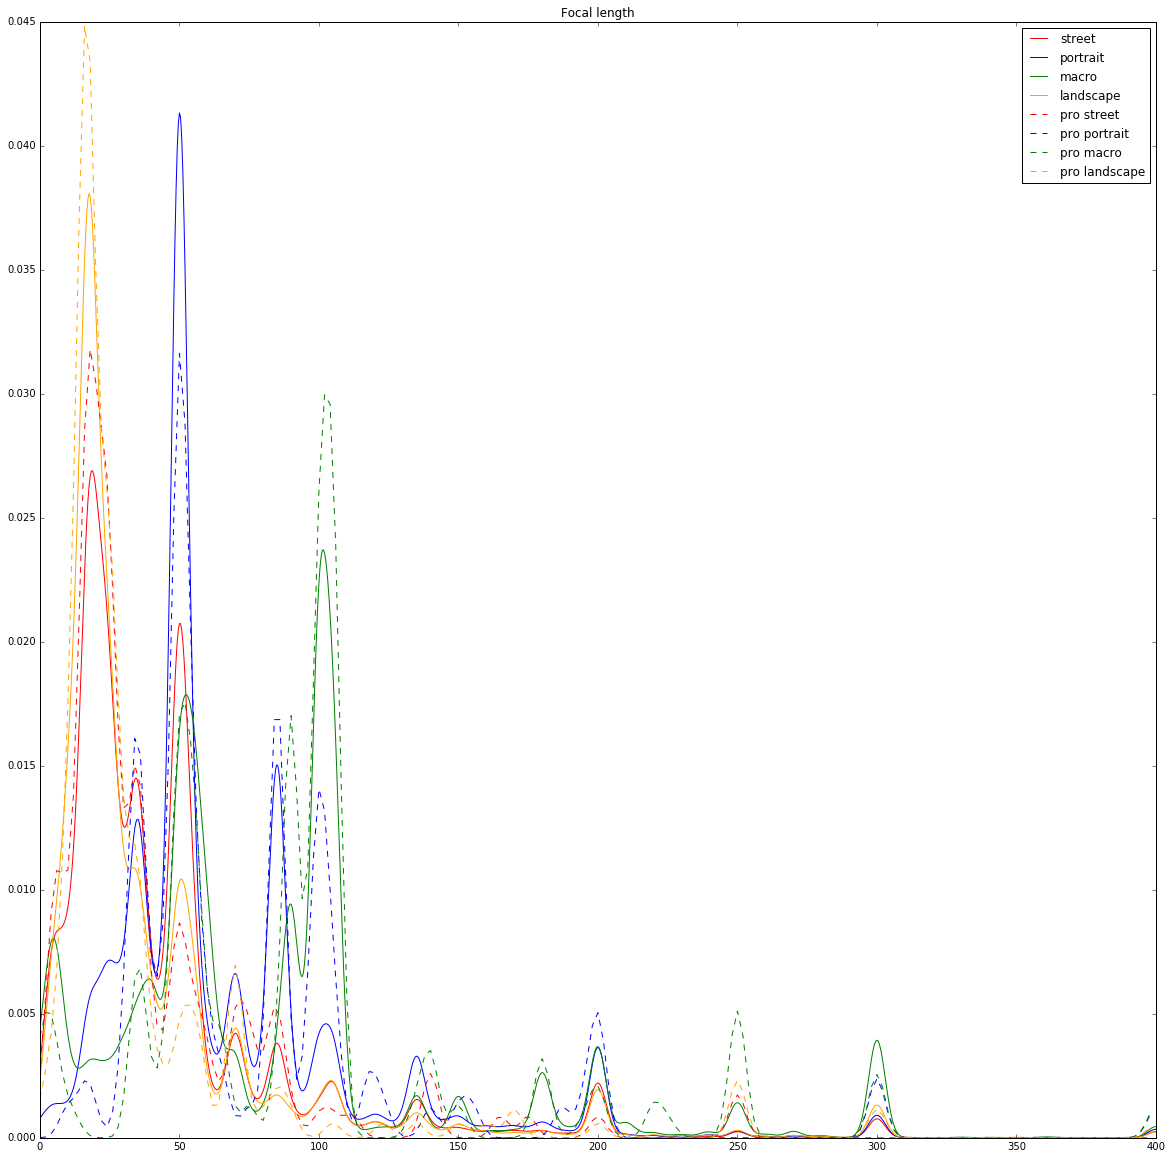

In [9]:
plt.figure(figsize=(20, 20))

for category in categories:
    x, y = single_value_chart(category['photos'], 'focal_length', 0., 400., 1000.)
    plt.plot(x, y, color=category["color"], label=category["name"])
    
for category in categories:
    x, y = single_value_chart(category['photos'], 'focal_length', 0., 400., 200., popular_only=True)
    plt.plot(x, y, color=category["color"], label='pro '+category["name"], ls='--')

plt.title("Focal length")
plt.legend()
plt.show()
plt.close()

__ISO__

ISO - czułość matrycy aparatu. Im bardziej ją zwiększymy, tym jaśniejsze będzie zdjęcie, kosztem zwiększonego szumu. Z powodów historycznych przyjmuje się wartość 100 jako neutralną. Mniejsze są zwykle sztucznie wymuszane przez body aparatu, większe stopniowo powodują większe szumy. Spodziewamy się przewagi ISO poniżej 400, bo w ten sposób najprościej uniknąć artefaktów. Wysokie wartości ISO są charakterystyczne dla reportarzu, w którym często trzeba fotografować bez lampy w kiepskich warunkach oświetleniowych.

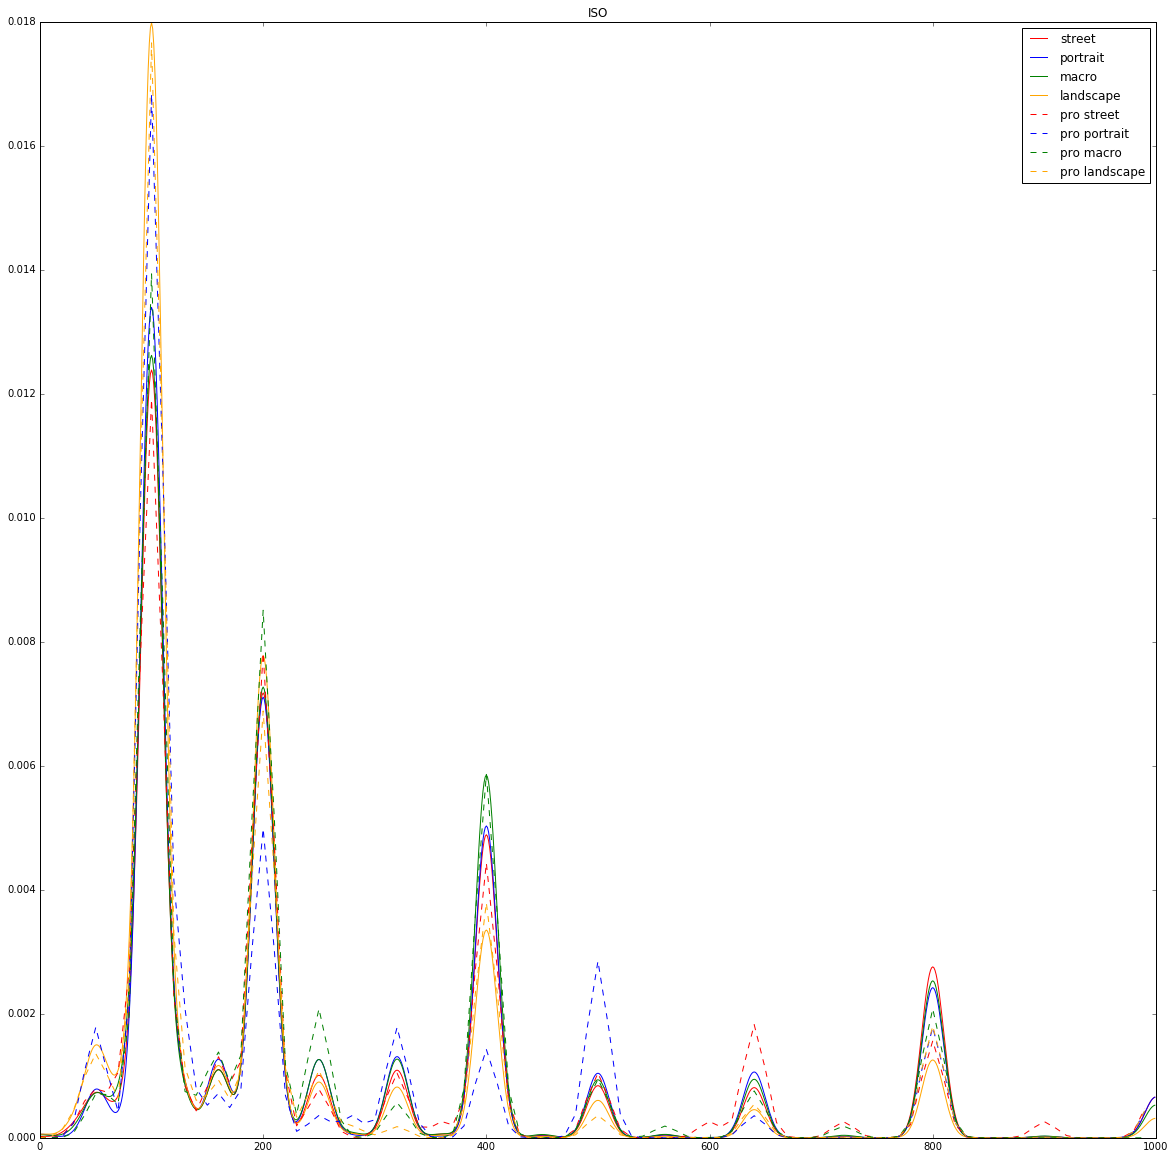

In [7]:
plt.figure(figsize=(20, 20))

for category in categories:
    x, y = single_value_chart(category['photos'], 'iso', 0., 1000., 1000., kernel_coef=10)
    plt.plot(x, y, color=category["color"], label=category["name"])

for category in categories:
    x, y = single_value_chart(category['photos'], 'iso', 0., 1000., 200., kernel_coef=10, popular_only=True)
    plt.plot(x, y, color=category["color"], label='pro '+category["name"], ls='--')

plt.title("ISO")
plt.legend()
plt.show()
plt.close()

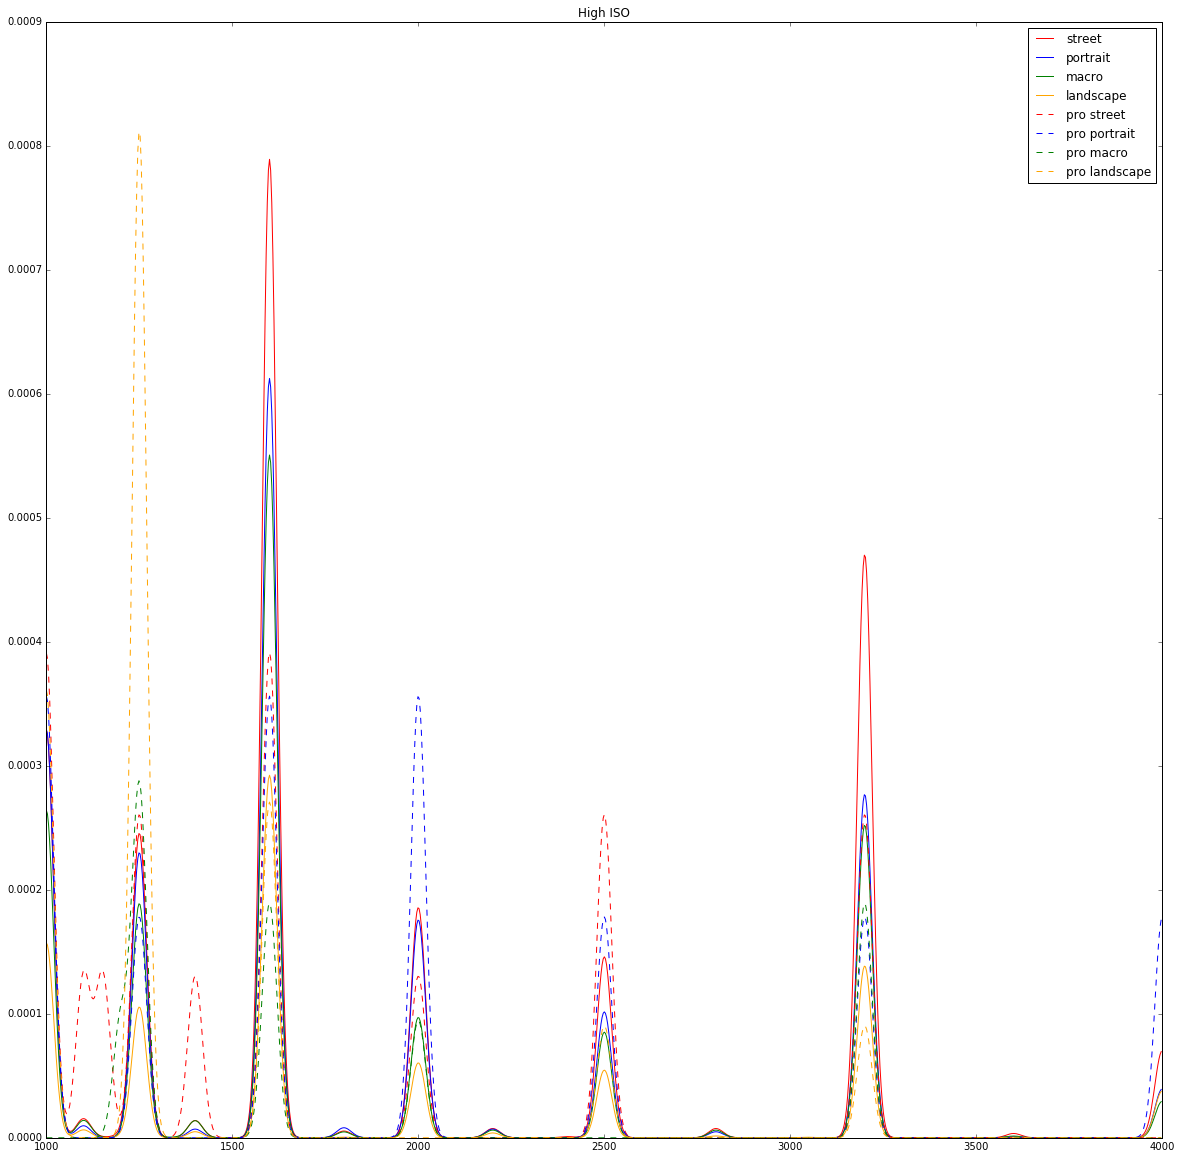

In [8]:
plt.figure(figsize=(20, 20))

for category in categories:
    x, y = single_value_chart(category['photos'], 'iso', 1000., 4000., 1000., kernel_coef=20)
    plt.plot(x, y, color=category["color"], label=category["name"])

for category in categories:
    x, y = single_value_chart(category['photos'], 'iso', 1000., 4000., 1000., kernel_coef=20, popular_only=True)
    plt.plot(x, y, color=category["color"], label='pro '+category["name"], ls='--')

plt.title("High ISO")
plt.legend()
plt.show()
plt.close()

__Przesłona__

Przesłona - część obiektywu regulująca wielkość otworu na drodze strumienia światła. Jej wartość oznacza się zwyczajowo jako $f/wartość$ i jest odwrotnie proporcjonalna do wielkości otworu względnego obiektywu, co oznacza, że większa liczba przysłony oznacza mniejszą ilość przepuszczanego światła. Z drugiej strony węższa przesłona oznacza mniejszy promień ostrości i charakterystyczne rozmycie tła. To efekt bardzo porządany przez portrecistów, bo zwraca więcej uwagi odbiory na fotografowaną postać, ale pejzażyści wolą go unikać, aby cały widok był równie ostry.

Najlepsze obiektywy osiągają wartości rzędu f/1.4, z maksimum ok. f/22.

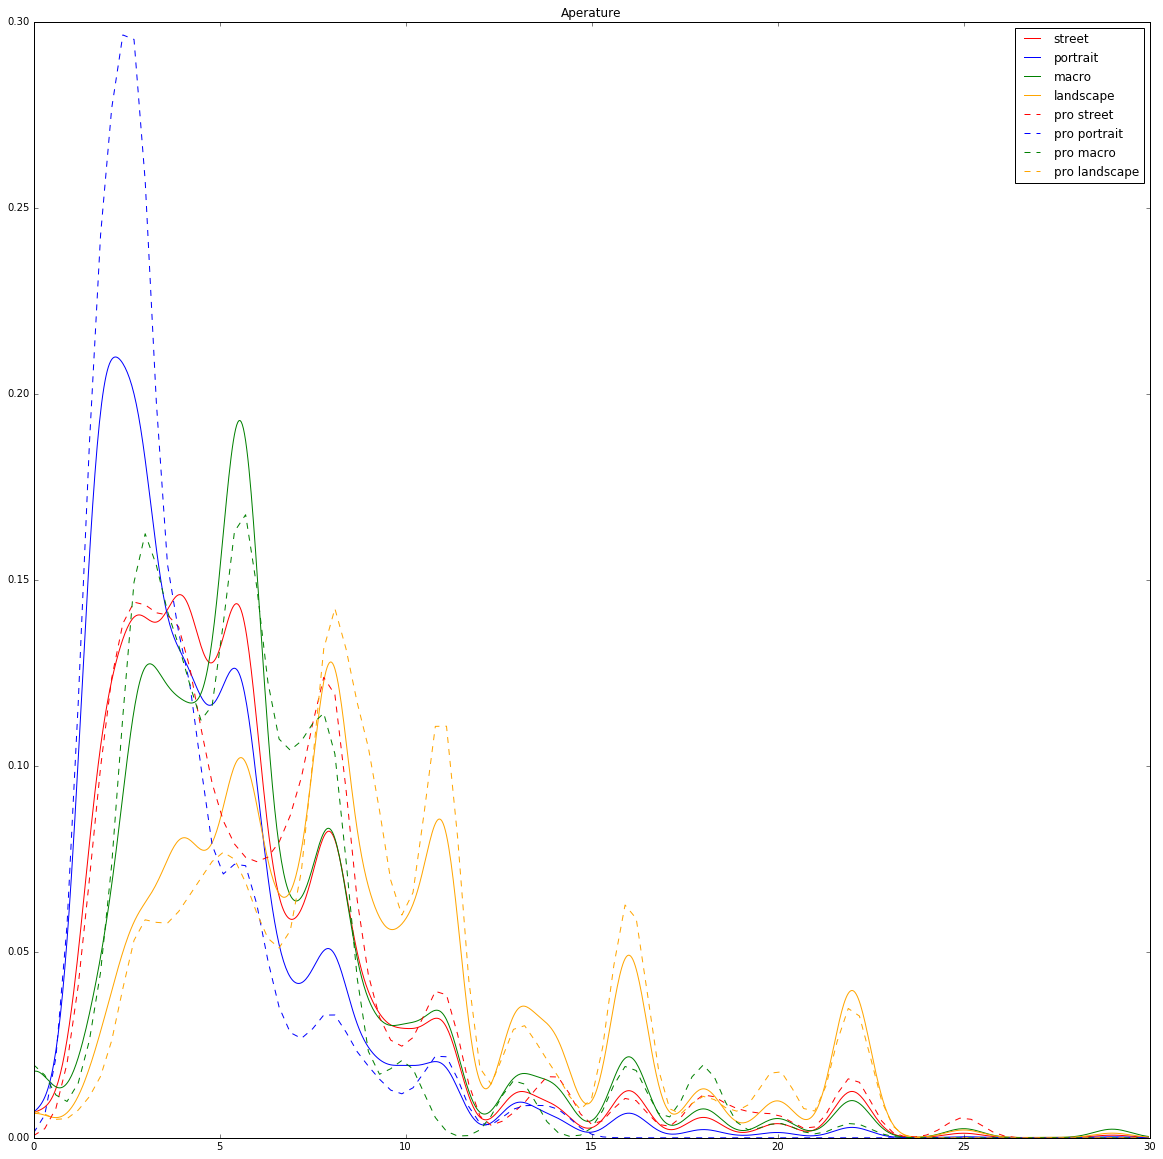

In [174]:
plt.figure(figsize=(20, 20))

for category in categories:
    x, y = single_value_chart(category['photos'], 'aperture', 0., 30., 1000., kernel_coef=0.5)
    plt.plot(x, y, color=category["color"], label=category["name"])

for category in categories:
    x, y = single_value_chart(category['photos'], 'aperture', 0., 30., 100., kernel_coef=0.5, popular_only=True)
    plt.plot(x, y, color=category["color"], label='pro '+category["name"], ls='--')


plt.title("Aperature")
plt.legend()
plt.show()
plt.close()

__Czas naświetlania__

Czas jak długo naświetlane jest zdjęcie. Im większy, tym zdjęcie jest jaśniejsze. Im mniejszy, tym mniej obiekty są rozmyte z powodu ruchu. Zwykle te wartości nie przekraczają 1/10s, aczkolwiek są wyjątki - w fotografii ulicznej nieraz chcemy "rozmyć" przechodniów, w pejzażu czasem naświetlanie trwa nawet parę minut. Daje to świetny efekt w połączeniu z chmurami i wodą.

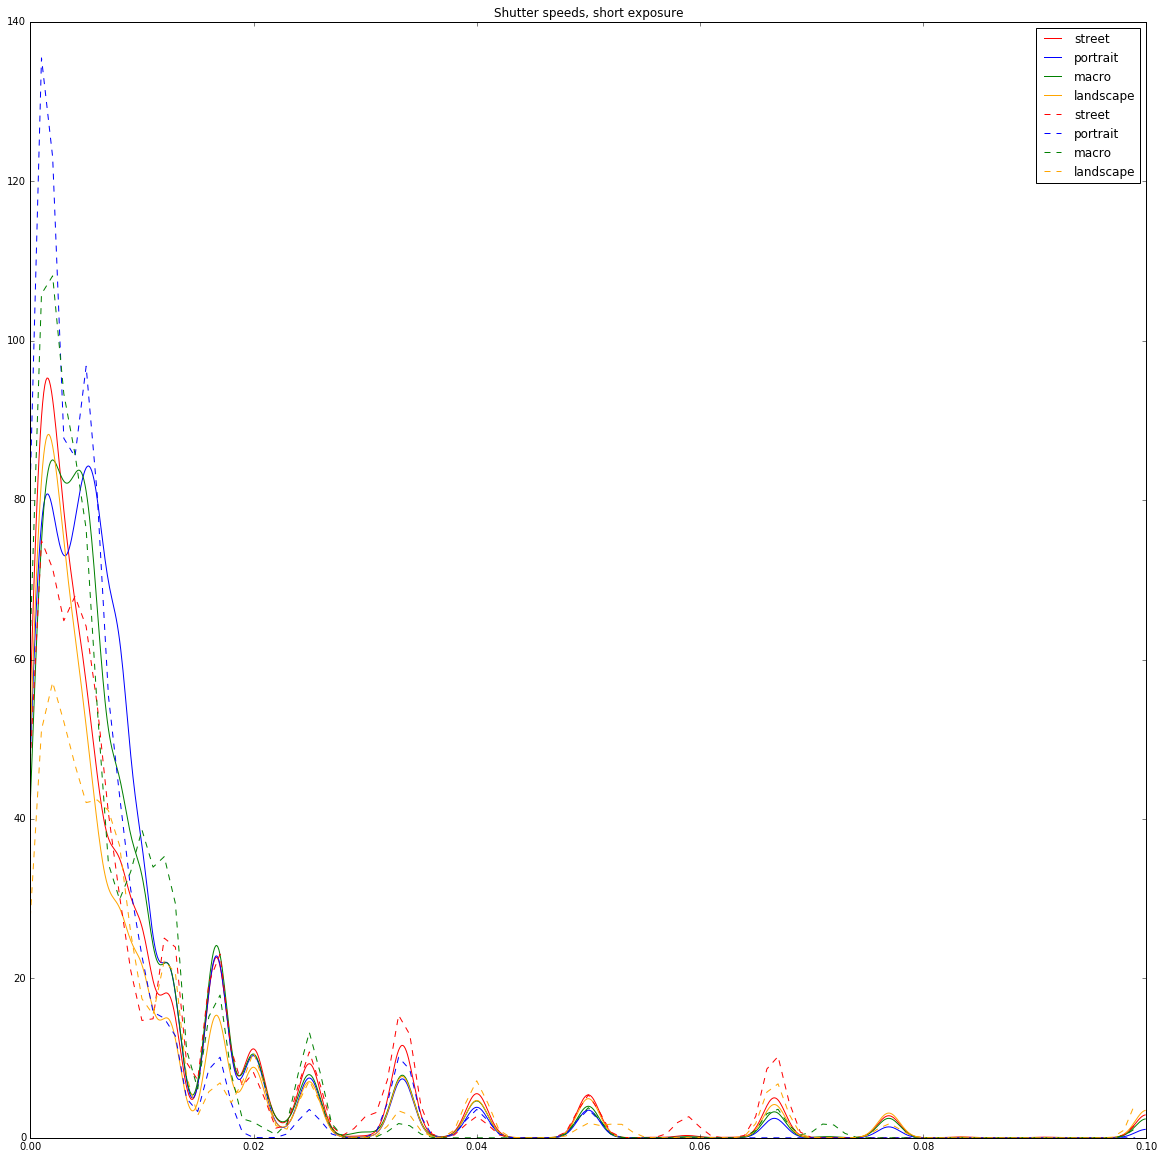

In [167]:
plt.figure(figsize=(20, 20))

for category in categories:
    x, y = single_value_chart(category['photos'], 'shutter_speed', 0., .1, 1000., kernel_coef=0.001)
    plt.plot(x, y, color=category["color"], label=category["name"])
    

for category in categories:
    x, y = single_value_chart(category['photos'], 'shutter_speed', 0., .1, 100., kernel_coef=0.001, popular_only=True)
    plt.plot(x, y, color=category["color"], label=category["name"], ls='--')
    
plt.title("Shutter speeds, short exposure")
plt.legend()
plt.show()
plt.close()

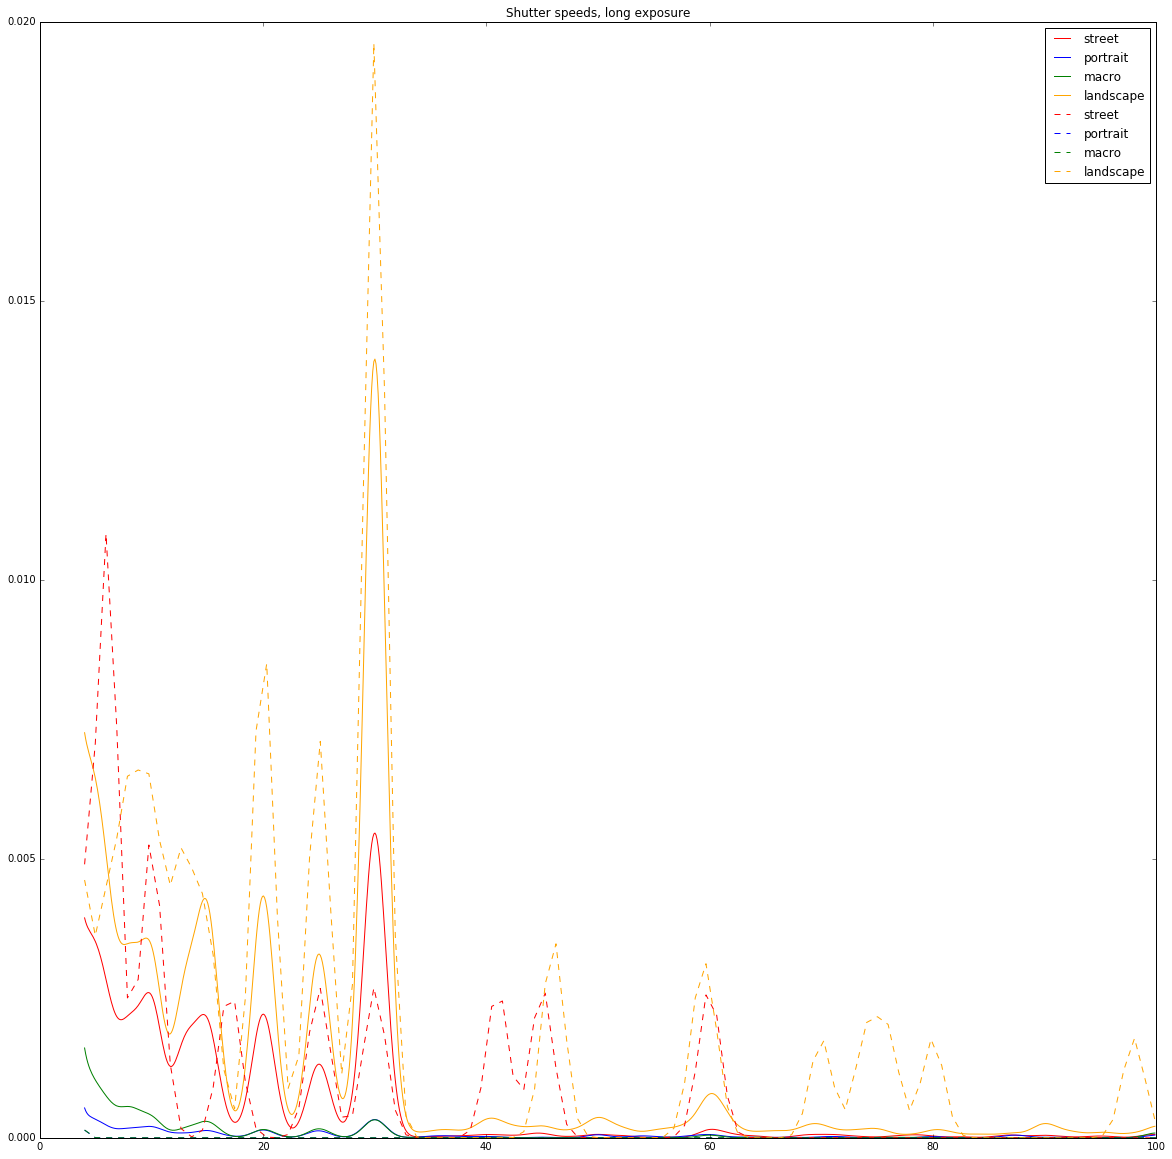

In [173]:
plt.figure(figsize=(20, 20))

for category in categories:
    x, y = single_value_chart(category['photos'], 'shutter_speed', 4., 100., 1000., kernel_coef=1.)
    plt.plot(x, y, color=category["color"], label=category["name"])
    

for category in categories:
    x, y = single_value_chart(category['photos'], 'shutter_speed', 4., 100., 100., kernel_coef=1., popular_only=True)
    plt.plot(x, y, color=category["color"], label=category["name"], ls='--')
    
plt.title("Shutter speeds, long exposure")
plt.legend()
plt.show()
plt.close()

__ Wnioski __

Tendecje ustawień w dużej mierze odpowiadają tym książkowym. Co więcej - widać wyraźnie, że 'zawodowcy' wykonują fotografie w sposób bliższy teoretycznemu ideałowi niż osoby uzyskujące gorsze wyniki. Można zatem zaufać podręcznikom i sugerować się nimi podczas fotografowania.

Wyraźne różnice w podejściu do fotografowania widać w kilku miejscach:
- W fotografi portretowej, "zawodowcy" wybierają dużo dłóższe ogniskowe i o wiele szerzej otwierają przesłony.
- Osoby z lepszymi wynikami nie boją się zwiększyć ISO. Niewielkie szumy można łatwo usunąć w postprocessingu.
- Dla czasów naświetlania powyżej 30s popularne zdjęcia bardzo się wyróżniają. Fotografie tego typu wymagają wiele wysiłku ale, jak widać, efekty często się podobają.
- W fotografii makro jednak przewagę mają dłuższe ogniskowe. Różnica się szczególnie uwypukla dla lepiej ocenianych zdjęć.

# 4. Ekwipunek


Od dekad panuje spór o to, czy należy wydać fortunę, żeby robić dobre zdjęcia. Poprzez analizę ocen i followerów zestawionych z kosztem sprzętu spróbujemy oszacować która ze stron konfliktu ma rację.

Żeby oszacować koszt ekwipunku posłużymy się wartościami body aparatów znalezionymi w serwisie Amazon. Cenę pozostałego osprzętu pomijam celowo - w bardzo wielu przypadkach znalezienie adekwatnej wartości jest wręcz niemożliwe. Wielu zawodowców używa obiektywów mających ponad 20 lat, podobnie jest z lampami błyskowymi i resztą osprzętu. 

Na oceny zdjęć popatrzymy dwojako - na liczbę głowów i na 'rate' - autorką ocenę serwisu 500px na bazie konwersji wyświetleń do 'polubień'. Dla wyników policzymy regresję liniową, żeby lepiej zwizualizować tendencje.



In [14]:
def import_last_week_photos():
    photos = []
    path = "photos_weekly"
    files = os.listdir(path)
    for file_name in files:
        if file_name.endswith(".json"):
            with open(os.path.join(path, file_name)) as json_file:
                json_data = json.load(json_file)
                photos += json_data["photos"]
    return photos

last_week_photos = import_last_week_photos()

In [ ]:
import requests
import os
import random

def download_user(user_id):
    path = os.path.join("users", str(user_id))
    if os.path.isfile(path):
        return
    URL = "https://api.500px.com/v1/users/show/?id={}&consumer_key=xISUtD32sTdW8Zk91HEUTdWx1Jc1W3EtDkjM7Tb4&".format(user_id)
    response = requests.get(URL)
    with open(path, 'w') as the_file:
        the_file.write(response.content)


photos_sample = random.sample(last_week_photos, 8000)
for photo in photos_sample:
    download_user(photo['user']['id'])

In [30]:
def import_users():
    users = []
    path = os.path.join("users")
    files = os.listdir(path)
    for file_name in files:
        with open(os.path.join(path, file_name)) as json_file:
            json_data = json.load(json_file)
            users.append(json_data)
    return users

users = import_users()

In [ ]:
cameras = {}
for user in users:
    if 'user' in user:
        if 'equipment' in user['user']:
            if 'camera' in user['user']['equipment']: 
                for camera in user['user']['equipment']['camera']:
                    if camera in cameras:
                        cameras[camera] = cameras[camera] + 1
                    else:
                        cameras[camera] = 1

cameras_data = list(reversed(sorted(zip(cameras.values(), cameras.keys()))))
for quantity, camera in cameras_data:
    download_amazon_price(camera)

In [37]:
def parse_price(price):
    # remove dolar sign and colons, parse as a float
    return float(price.replace('$', '').replace(',', ''))
    
def import_prices():
    products_prices = {}
    path = "prices"
    files = os.listdir(path)
    for file_name in files:
        with open(os.path.join(path, file_name)) as price:
            products_prices[file_name] = parse_price(price.read())
    return products_prices

products_prices = import_prices()

In [38]:
print "Najpopularniejsze aparaty i ich ceny"

for quantity, camera in cameras_data[:10]:
    print camera+":\t", products_prices[encode_product_name(camera)]

Najpopularniejsze aparaty i ich ceny
Nikon D7000:	469.95
Nikon D90:	899.99
Nikon D800:	2499.95
Canon 6D:	1499.0
Nikon D7100:	896.95
Canon 7D:	899.0
Nikon D750:	1996.95
Canon EOS 6D:	1499.0
Nikon D700:	2599.99
Nikon D810:	2796.95


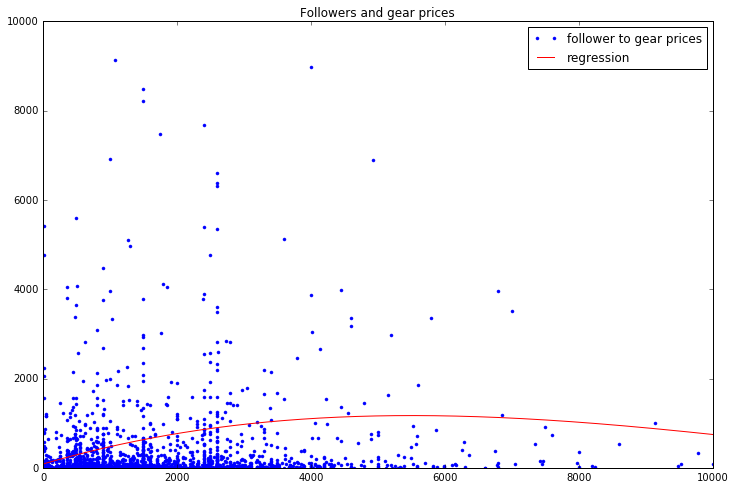

In [44]:
followers = []
expenses = []

for user in users:
    if "user" in user:
        followers_count = user['user']['followers_count']
        gear_price = 0
        if 'equipment' in user['user']:
            if 'camera' in user['user']['equipment']: 
                for camera in user['user']['equipment']['camera']:
                    gear_price += get_product_price(camera, products_prices)
        if followers_count > 0 and gear_price > 0.:
            followers.append(followers_count)
            expenses.append(gear_price)

plt.ylim([0,10000])
plt.xlim([0,10000])
plt.plot(expenses, followers, ".", label="follower to gear prices")

clf = make_pipeline(PolynomialFeatures(3), linear_model.ElasticNet(max_iter=10000))
clf.fit([[e] for e in expenses], followers)

x_vals = np.linspace(0., 10000., num=1000)
y_vals = clf.predict([[e] for e in x_vals])

plt.plot(x_vals, y_vals, color='r', label="regression")
plt.title("Followers and gear prices")
plt.legend()
plt.show()
plt.close()

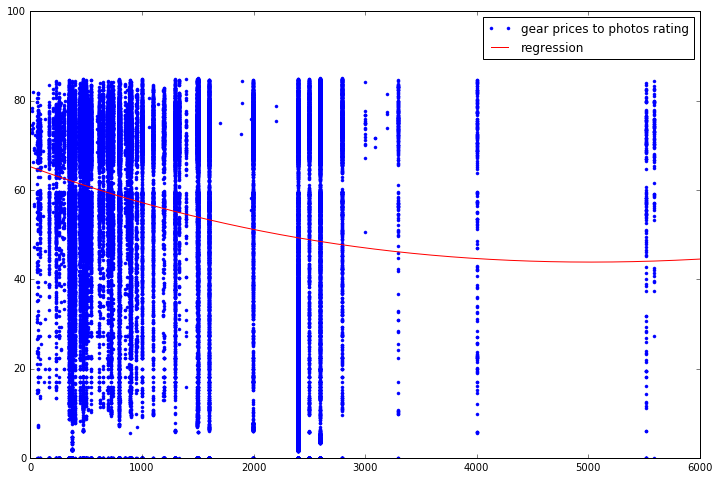

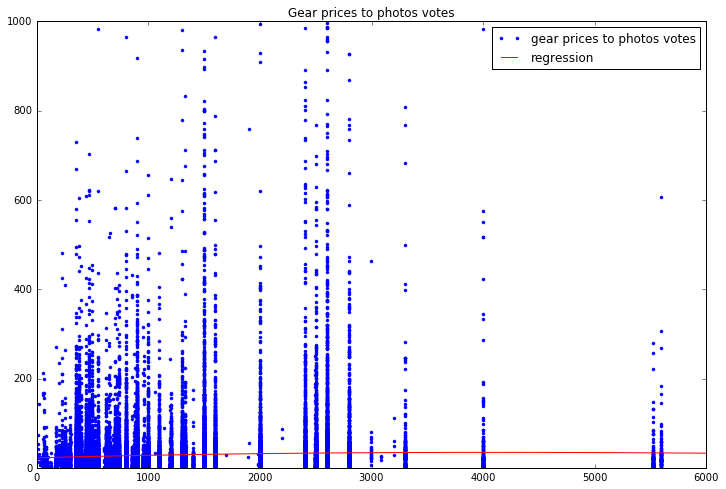

In [46]:
photos_rating = []
photos_votes = []
photos_price = []

for photo in last_week_photos:
    rating = photo['rating']
    votes = photo['votes_count']
    price = get_product_price(photo['camera'], products_prices)
    if price > 0.:
        photos_rating.append(rating)
        photos_price.append(price)
        photos_votes.append(votes)
        
plt.ylim([0,100])
plt.xlim([0,6000])
plt.plot(photos_price, photos_rating, '.', label='gear prices to photos rating')

clf = make_pipeline(PolynomialFeatures(3), linear_model.ElasticNet(max_iter=10000))
# clf = linear_model.ElasticNet()
clf.fit([[e] for e in photos_price], photos_rating)

x_vals = np.linspace(0., 6000., num=1000)
y_vals = clf.predict([[e] for e in x_vals])

plt.plot(x_vals, y_vals, color='r', label='regression')
plt.legend()
plt.show()
plt.close()


plt.ylim([0,1000])
plt.xlim([0,6000])
plt.plot(photos_price, photos_votes, '.', label='gear prices to photos votes')

clf = make_pipeline(PolynomialFeatures(3), linear_model.ElasticNet(max_iter=10000))
clf.fit([[e] for e in photos_price], photos_votes)

x_vals = np.linspace(0., 6000., num=1000)
y_vals = clf.predict([[e] for e in x_vals])

plt.plot(x_vals, y_vals, color='r', label='regression')
plt.title('Gear prices to photos votes')
plt.legend()
plt.show()
plt.close()

__Telefony komórkowe__

Dodatkowo przyjrzyjmy się telefonom komórkowym. Każdy z nas ma cyfrowy aprat w kieszeni, ale czy jest on w stanie zastąpić pełnoprawną lustrzankę?

Zdjęcia telefonem:  3674
Pozostałe:  71235


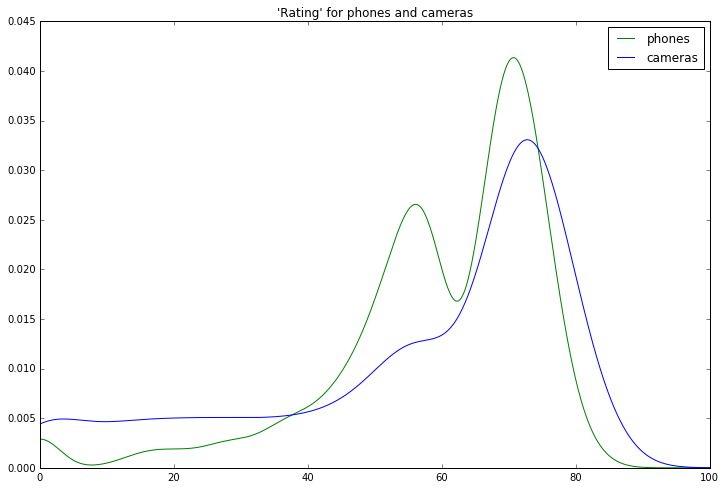

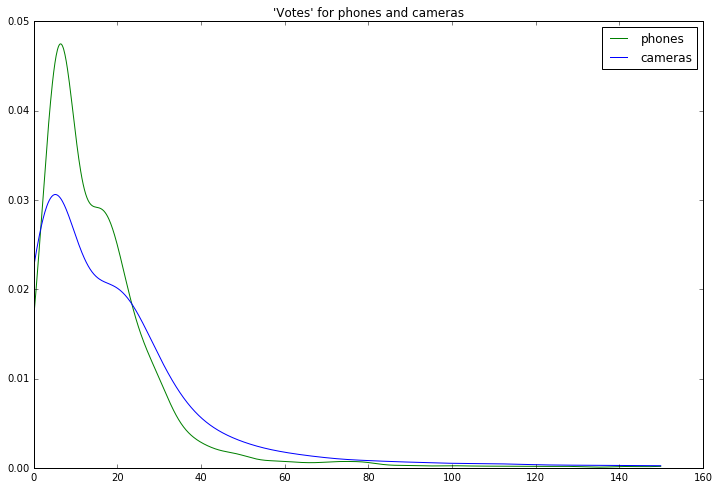

In [28]:
phones_rating = []
non_phones_rating = []

phones_votes = []
non_phones_votes = []

phone_names = ['iphone', 'nokia', 'samsung', 'xperia', 'htc', 'huawei', 'galaxy', 'apple', 'android', 'nexus', 'asus', 'lg']

def multi_contains(name, patterns):
    for pattern in patterns:
        if pattern in name:
            return True
    return False

for photo in last_week_photos:
    camera = photo['camera']
    votes = photo['votes_count']
    rating = photo['rating']
    if camera:
        if multi_contains(camera.lower(), phone_names):
            phones_votes.append(votes)
            phones_rating.append(rating)
        else: 
            non_phones_votes.append(votes)
            non_phones_rating.append(rating)

print "Zdjęcia telefonem: ", len(phones_rating)
print "Pozostałe: ", len(non_phones_rating)

kde = scipy.stats.gaussian_kde(phones_rating, bw_method=3/np.asarray(phones_rating).std(ddof=1))
begin = 0.
end = 100.
n = 1000
x = [i for i in frange(begin, end, (end - begin)/n)]
y = [kde(_x) for _x in x]

plt.plot(x, y, color='green', label="phones")

kde = scipy.stats.gaussian_kde(non_phones_rating, bw_method=5/np.asarray(non_phones_rating).std(ddof=1))

x = [i for i in frange(begin, end, (end - begin)/n)]
y = [kde(_x) for _x in x]

plt.plot(x, y, color='blue', label="cameras")
plt.title("'Rating' for phones and cameras")
plt.legend()
plt.show()
plt.close()



kde = scipy.stats.gaussian_kde(phones_votes, bw_method=3/np.asarray(phones_votes).std(ddof=1))
begin = 0.
end = 150.
n = 1000
x = [i for i in frange(begin, end, (end - begin)/n)]
y = [kde(_x) for _x in x]

plt.plot(x, y, color='green', label="phones")

kde = scipy.stats.gaussian_kde(non_phones_votes, bw_method=5/np.asarray(non_phones_votes).std(ddof=1))

x = [i for i in frange(begin, end, (end - begin)/n)]
y = [kde(_x) for _x in x]

plt.plot(x, y, color='blue', label="cameras")
plt.title("'Votes' for phones and cameras")
plt.legend()
plt.show()
plt.close()

__Wnioski__

To niesamowite, ale faktycznie nie widać przełożenia wartości sprzętu na wyniki. Zarówno dla zdjęć jak i dla fotografów przelicznik ocen do wydatków jest wyraźnie kiepski i wskazuje na to, że rzeczywiście jakość zdjęcia zależy bardziej od tego, kto go robi niż czym.

Porównanie aparatów do telefonów wypada jednak dużo lepiej na korzyść profesjonalnego sprzętu. 

Na bazie powyższego można wysnuć wniosek, że najbardziej opłaca się niedrogi aparat cyfrowy.

# Tagi


Każde zdjęcie może być otagowane, tj. mieć przypisany szereg haseł, które się z nim kojarzą. Postaramy się znaleźć tendencje poprzez klastrowanie tagów. 

Ponieważ tagi są wpisywane przez użytkowników, mogą się różnić pisownią. Żeby znormalizować takie dane pozbywamy się białych znaków, znaków nie-alfanumerycznych, na końcu czcionkę na małą.

Aby móc mówić o klastrowaniu, trzeba najpierw zdefiniować metrykę. Przejrzymy wszystkie zdjęcia, każdej parze tagów damy punkt jeśli wystąpiła razem w jednym zdjęciu. 

Do klastrowania posłuży nam algorytm klastrowania aglomeracyjnego. Ponieważ miałem problemy z użyciem gotowego rozwiązania na takich danych, napisałem własną, prostą wersję tego algorytmu. Do porównania odległości między klastramy posłużymy się średnią odległością elementów. Rozpatrując najbliższe możemy mieć problem z tym, że popularny tag przyciągnie do siebie wiele nieskorelowanych wartości.
Klastrowanie aglomeracyjne zostało wybrane by móc odtworzyć "ciąg skojarzeń" zamiast samych klastrów podobnych wartości.

In [ ]:
def import_tags():
    tags = []
    tagged_n = 0
    for photo in last_week_photos:
        tags += photo['tags']
        if photo['tags']:
            tagged_n += 1
    print tagged_n
    return tags

tags = import_tags()

In [ ]:
def normalize_tag(tag):
    delchars = ''.join(c for c in map(chr, range(256)) if not c.isalnum())
    return ''.join(ch for ch in tag if ch.isalnum()).lower()

normalized = [normalize_tag(tag) for tag in tags]
tags_count = {}
for tag in normalized:
    if tag in tags_count:
        tags_count[tag] = tags_count[tag] + 1
    else:
        tags_count[tag] = 1

tags_count.pop('', None)

popular_tags = []
for tag, quantity in tags_count.iteritems():
    if quantity >= 100:
        popular_tags.append(tag)

popular_tags = set(popular_tags)

In [ ]:
photos_with_tags = 0
photos_with_popular_tags = 0

for photo in last_week_photos:
    popular_tags_count = 0
    for tag in photo['tags']:
        if tag in popular_tags:
            popular_tags_count += 1
    if photo['tags']:
        photos_with_tags += 1
    if popular_tags_count > 0:
        photos_with_popular_tags += 1

In [ ]:
popular_tags = list(popular_tags)
rev_popular_tags = {}
for i in range(len(popular_tags)):
    rev_popular_tags[popular_tags[i]] = i

distances = np.zeros((len(popular_tags), len(popular_tags)))
count = 0
for photo in last_week_photos:
    count += 1
    if count%500 == 0:
        print count
    if photo['tags']:
        current_tags = photo['tags']
        for i in range(len(current_tags)):
            if normalize_tag(current_tags[i]) in rev_popular_tags:
                for j in range(i+1, len(current_tags)):
                    if normalize_tag(current_tags[j]) in rev_popular_tags and normalize_tag(current_tags[i]) != normalize_tag(current_tags[j]):
                        ind_i = rev_popular_tags[normalize_tag(current_tags[i])]
                        ind_j = rev_popular_tags[normalize_tag(current_tags[j])]
                        distances[ind_i][ind_j] += 1
                        distances[ind_j][ind_i] += 1

In [38]:
metric = 1./(distances + 1.)
cluster_to_tags = {}
tag_to_cluster = {}
for i in range(len(tag_predictions)):
    current_tag_name = popular_tags[i]
    tag_to_cluster[current_tag_name] = tag_predictions[i]
    if tag_predictions[i] not in cluster_to_tags:
        cluster_to_tags[tag_predictions[i]] = []
    cluster_to_tags[tag_predictions[i]] = cluster_to_tags[tag_predictions[i]] + [current_tag_name]


In [ ]:
from sets import Set

def clusters_distance(cl1, cl2, distances_matrix, method='nearest'):
    all_distances = []
    for el1 in cl1:
        for el2 in cl2:
            all_distances += [distances_matrix[el1][el2]]
    if method == 'nearest':
        return min(all_distances)
    elif method == 'average':
        return sum(all_distances)/len(all_distances)
    elif method == 'farthest':
        return max(all_distances)
    else:
        raise ValueError("Possible methods are: ['nearest', 'average', 'farthest']")

def agglomerative_clustering(distances_matrix, clusters_n=10, method='nearest', max_dist=100.):
    cls = [[i] for i in range(len(distances_matrix))]
    
    while len(cls) > clusters_n:
        print len(cls)
        best_cl1 = []
        best_cl2 = []
        closest = max_dist
        for i in range(len(cls)):
            for j in range(i+1, len(cls)):
                cl1 = cls[i]
                cl2 = cls[j]
                current_dist = clusters_distance(cl1=cl1, cl2=cl2, distances_matrix=distances_matrix, method=method)
                if current_dist < closest:
                    closest = current_dist
                    best_cl1 = cl1
                    best_cl2 = cl2
        cls.remove(best_cl1)
        cls.remove(best_cl2)
        cls.append(best_cl1 + best_cl2)
    return cls

cls = agglomerative_clustering(metric, clusters_n=250, method='average')

In [321]:
for cluster in cls:
    if len(cluster) > 4:
        print '(' + ", ".join([popular_tags[i] for i in cluster]) + ")"

(mtsac, dreamact, dreamprogramceremony, jeffreygeorge, californiadreamact, dreamers)
(naughtyboy, hotbody, newlook, tribhuwan, trigurjar, coolboy, graphicdesignertribhuwangurjar, gurjar, gurjarboy, mechanicalengineer, bhilwaragurjar, sikerjaipur, tribhu, jaipurgurjar, actor, enjoying, attractive, handsome, cool, tri, tribhuwangurjar)
(jekta, tromsfylke, busspassasjer, bussholdeplass, fylkestrafikk, mann, tromsfylkestrafikk, kvinne, familie, tromsø, barn, troms, holdeplass, buss, nerstranda)
(alcala, henares, plants, buildings, shadows, lights)
(botanical, botanic, monte, madeira, funchal, jardim, ornamental, japanese)
(jakarta, indonesian, java, indonesia, ruin, yogyakarta, jogjakarta)
(toronto, canada, ontario, marriage, groom, bride, wedding, love, couple)
(lamp, glass, mall, store, shop, shopping, market, sale, arabic, craft, oriental)
(movement, toy, game, play, recreation, entertainment, youth, joy)
(himalayas, leh, gompa, tibet, tibetan, ladakh, kashmir)
(ukraine, airport, flying

__Wnioski__

Jak widać, tagi są pogrupowane w sposób bardzo logiczny. W jednym klastrze lądują słowa kluczowe bardzo zbliżone do siebie. Oznacza to, że użytkownicy 500px przykładają dużą uwagę do opisów swoich fotografii.

Z tak zrobionego podziału możemy wysnuć bardzo wiele wniosków. 
- Europa jest mocno skojarzona z Chrześcijaństwem
- Bokeh jest charakterystyczny dla fotografii makro
- HDR jest powszechnie używany w eksploracj miejskiej 
- Handel i stragany są mocno skojarzone z orientem
- Kemping jest bardzo popularny w południowych stanach USA

I wiele, wiele innych. 

# Lokacje

Na koniec popatrzymy jak rozkładają się lokalizacje, w których robi się fotografie. Około 30% zdjęć ma zapisane dane geolokacyjne, możemy więc liczyć na pewne tendencje.

In [15]:
coords = []
for photo in last_week_photos:
    if photo['latitude'] and photo['longitude']:
        coords.append((photo['latitude'], photo['longitude']))

In [16]:
lats = []
lons = []
for a, b in coords:
    lats.append(a)
    lons.append(b)

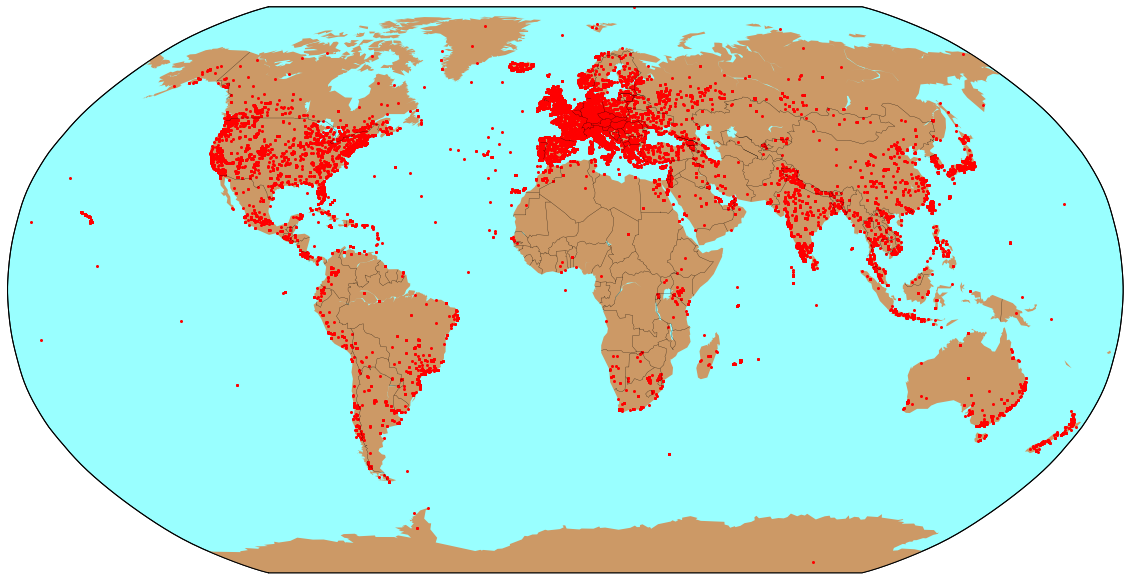

In [17]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def plot_geo(X, Y, color="g", output=None):
    plt.clf()
    plt.figure(figsize=(20, 20))
    m = Basemap(projection='robin', lon_0=0.)
    x, y = m(X, Y)
    m.scatter(x,y,4,color=color, marker='o')
    m.drawmapboundary(fill_color='#99ffff')
    m.fillcontinents(color='#cc9966',lake_color='#99ffff', zorder=0)
    m.drawcountries(linewidth=0.25)

    if output:
        plt.savefig(output, dpi=500)
    else:
        plt.show()

    
plot_geo(lons, lats, color='r')

Na powyższej mapce znajduje się ok 33 punktów. Bardzo dobrze pokazuje, które obszary są gęsto zamieszkałe przez bardziej przez bardziej majętne jednostki. Pokazuje też, że 500px, podobnie jak wiele innych serwisów, jest mało popularny w Rosji i Chinach.

Na koniec zobaczmy co się stanie, jeśli sklastrujemy wyniki. Przy użyciu algorytmu K-means spróbujemy pogrupować geolokacje w klastry licząc, że znajdziemy popularne miejsca na fotografowanie. Użyjemy k-means, gdyż zależy nam na klastrach puntków, będących w skupiskach na mapie.

In [ ]:
zipped = zip(lons, lats)

from sklearn.cluster import KMeans

clf = KMeans(n_clusters=300, n_jobs=6, init='random', max_iter=5000, tol=0.00000001)
clf.fit(zipped)

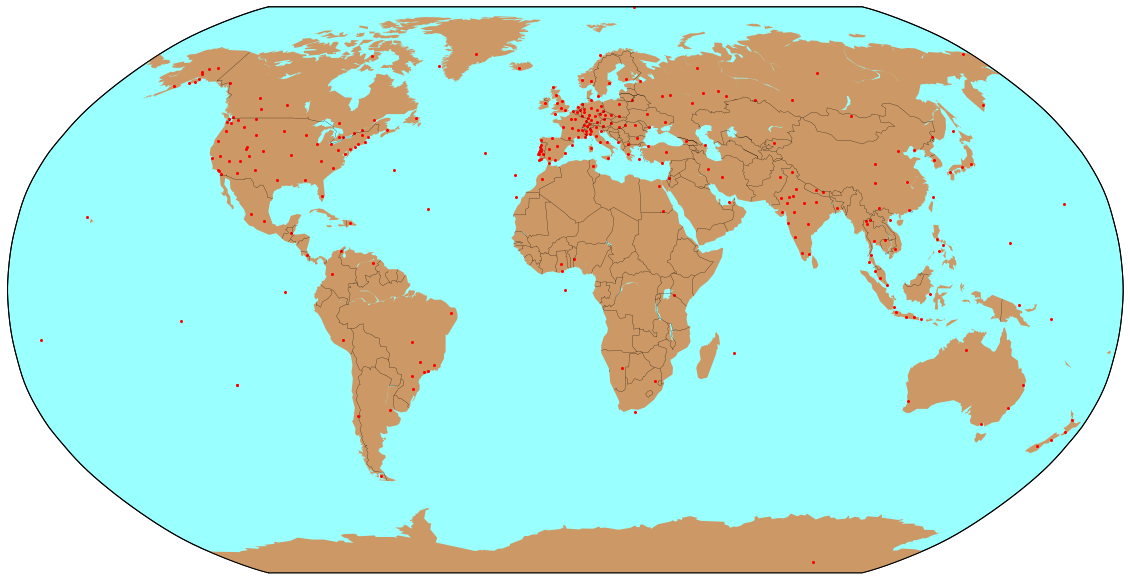

In [19]:
centers = clf.cluster_centers_
ctr_x, ctr_y = np.transpose(np.array(centers))
plot_geo(ctr_x, ctr_y, color='r')

To jest wynik, z którego jestem najbardziej zadowolony - centra klastrów z K-means w doskonały sposób wyznaczają ciekawe miejsca. Prócz stolic i większych miast (Tokio, Paryż, Nowy Jork, Kraków) centra z bardzo dużą dokładnością wyznaczają ciekawe miejsca tj. Yosemite National Park albo Wodospad Niagara. 

# Podsumowanie i wnioski

Fotografia jest dziedziną niezmiernie ciekawą. Mimo bycia dziedziną sztuki, jest w niej bardzo wiele ścisłości. Analizując dane możemy zauważyc schematy, które pomogą nam rozwinąć umiejętności.

W powyższej pracy skupiliśmy się na czterech aspektach:
- technikaliach podczas robienia zdjęć - dowiedzieliśmy się m.in., że w portretach warto szerzej otworzyć przesłonę, że super-długa ekspozycja przynosi świetne efekty i że nie należy się bać podwyższać ISO
- kosztach sprzętu - pokazaliśmy, że faktycznie cena sprzętu nie gra roli jeśli chodzi o szanse na sukces
- tagach - znaleźliśmy wiele zależności i skojarzeń między opisami fotografowanych przedmiotów
- lokacjach - pokazaliśmy, że fotografia koncenruje się w dużych miastach i ciekawych obiektach przyrodniczych